In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("./StudentsPerformance.csv")

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### 1. Missing Values and Inconsistencies

In [2]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [2]:
df['test preparation course'].unique()

array(['none', 'completed'], dtype=object)

In [3]:
# Convert columns to catergorical
categorical = ['gender', 'race/ethnicity', 'parental level of education', "lunch", "test preparation course"]

for col in categorical:
    df[col] = df[col].astype("category")
    
df.dtypes

gender                         category
race/ethnicity                 category
parental level of education    category
lunch                          category
test preparation course        category
math score                        int64
reading score                     int64
writing score                     int64
dtype: object

In [5]:
# Standardize the column names
df.columns = df.columns.str.replace(' ', '_')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       1000 non-null   category
 1   race/ethnicity               1000 non-null   category
 2   parental_level_of_education  1000 non-null   category
 3   lunch                        1000 non-null   category
 4   test_preparation_course      1000 non-null   category
 5   math_score                   1000 non-null   int64   
 6   reading_score                1000 non-null   int64   
 7   writing_score                1000 non-null   int64   
dtypes: category(5), int64(3)
memory usage: 29.2 KB


### 2. Outliers

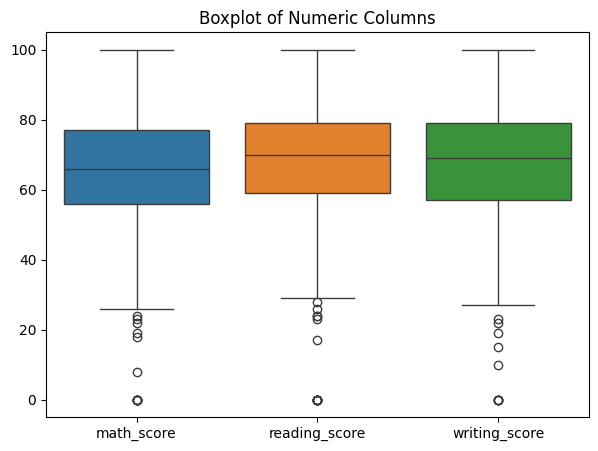

In [6]:
# box plot for Outlier
plt.figure(figsize=(7, 5))
sns.boxplot(data=df.select_dtypes(["int64"]))
plt.title('Boxplot of Numeric Columns')
plt.show()

In [7]:
numeric_cols = df.select_dtypes(include=['int64'])
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

print("IQR Lower Range: ", Q1 - 1.5 * IQR)
print("\nIQR Upper Range: ", Q3 + 1.5 * IQR)

outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))

numeric_cols['math_score'].loc[outliers['math_score'] == True]

IQR Lower Range:  math_score       24.5
reading_score    29.0
writing_score    24.0
dtype: float64

IQR Upper Range:  math_score       108.5
reading_score    109.0
writing_score    112.0
dtype: float64


14      0
17     18
40      0
59      0
83      0
126     0
145    22
197     0
282     0
338    24
787    19
842    23
963     0
980     8
Name: math_score, dtype: int64

In [8]:
numeric_cols['reading_score'].loc[outliers['reading_score'] == True]

8       0
59     17
69      0
76     26
115     0
143     0
161     0
175     0
211    28
224     0
242     0
327    23
596    24
974     0
975     0
980    24
996     0
Name: reading_score, dtype: int64

In [9]:
numeric_cols['writing_score'].loc[outliers['writing_score'] == True]

23      0
54      0
59     10
76     22
96      0
261     0
327    19
596    15
980    23
993     0
Name: writing_score, dtype: int64

In [10]:
# Drop the outliers and create new DatFrame from remaining data
new_df = df.copy()

new_df[numeric_cols.columns] = new_df[numeric_cols.columns].where(~outliers[numeric_cols.columns], np.nan)

new_df.dropna(inplace=True)

In [11]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       966 non-null    category
 1   race/ethnicity               966 non-null    category
 2   parental_level_of_education  966 non-null    category
 3   lunch                        966 non-null    category
 4   test_preparation_course      966 non-null    category
 5   math_score                   966 non-null    float64 
 6   reading_score                966 non-null    float64 
 7   writing_score                966 non-null    float64 
dtypes: category(5), float64(3)
memory usage: 35.7 KB


### 3. Data Transformations

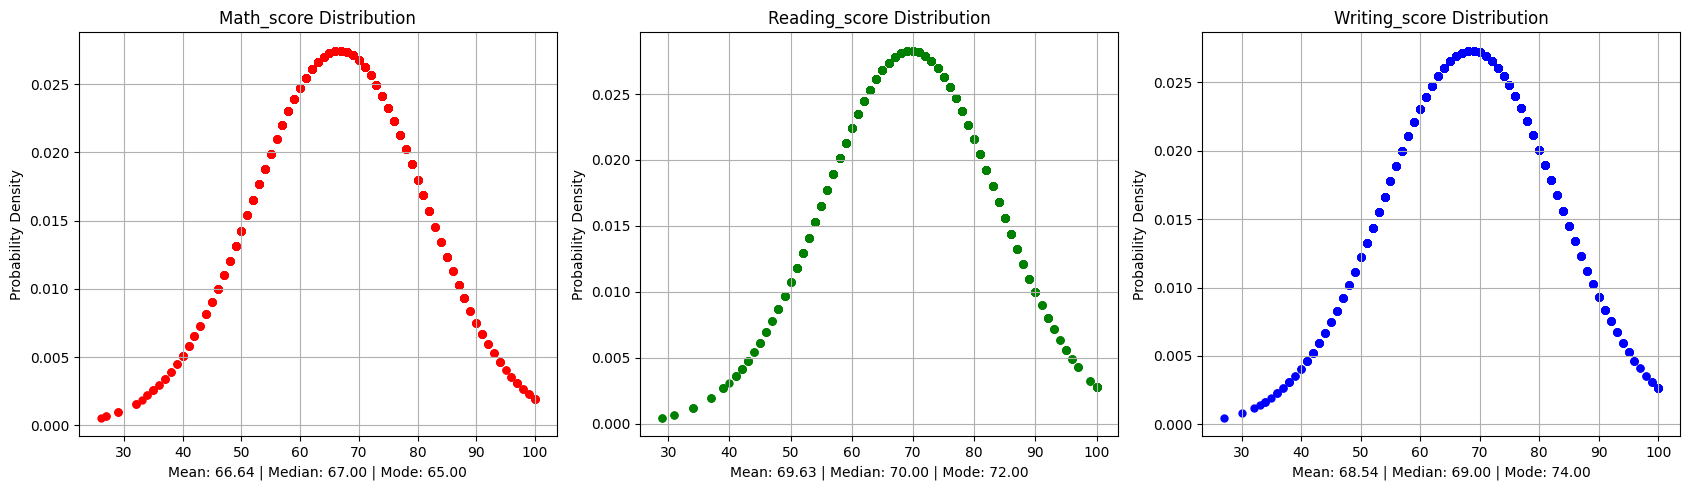

math_score      -0.056621
reading_score   -0.121892
writing_score   -0.112473
dtype: float64

In [16]:
import statistics as st

def pdf(x, subject): 
    mean = np.mean(x) 
    std = np.std(x) 
    median = np.median(x)
    mode = st.mode(x)
    
    y_out = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(- (x - mean) ** 2 / (2 * std ** 2)) 
    return y_out, mean, median, mode

subjects = ["math_score", "reading_score", "writing_score"]
colors = ["red", "green", "blue"]

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, subject in enumerate(subjects):
    x = np.array(new_df[subject])
    y, mean, median, mode = pdf(x, subject)
    
    axes[i].scatter(x, y, marker='o', s=25, color=colors[i])
    axes[i].set_title(f"{subject.capitalize()} Distribution")
    axes[i].set_xlabel(f"Mean: {mean:.2f} | Median: {median:.2f} | Mode: {mode:.2f}")
    axes[i].set_ylabel("Probability Density")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

new_df[[*subjects]].skew()

Data is already normally distributed as mean ≈ median ≈ mode AND since -0.5 < skewness < 0.5 for all variables

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply Min-Max Scaling (0 to 1 range)
new_df["math_scaled"] = minmax_scaler.fit_transform(new_df[["math_score"]])
new_df["reading_scaled"] = minmax_scaler.fit_transform(new_df[["reading_score"]])
new_df["writing_scaled"] = minmax_scaler.fit_transform(new_df[["writing_score"]])

# Apply Z-score Standardization (mean = 0, std = 1)
new_df["math_standardized"] = standard_scaler.fit_transform(new_df[["math_score"]])
new_df["reading_standardized"] = standard_scaler.fit_transform(new_df[["reading_score"]])
new_df["writing_standardized"] = standard_scaler.fit_transform(new_df[["writing_score"]])

new_df[['math_standardized', 'reading_standardized', 'writing_standardized']].corr()

,math_standardized,reading_standardized,writing_standardized
math_standardized,1.000000,0.80492,0.786311
reading_standardized,0.804920,1.00000,0.950880
writing_standardized,0.786311,0.95088,1.000000


In [14]:
new_df.head(10)

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,math_scaled,reading_scaled,writing_scaled,math_standardized,reading_standardized,writing_standardized
0,female,group B,bachelor's degree,standard,none,72.0,72.0,74.0,0.621622,0.605634,0.643836,0.368917,0.168284,0.373721
1,female,group C,some college,standard,completed,69.0,90.0,88.0,0.581081,0.859155,0.835616,0.162364,1.444955,1.332408
2,female,group B,master's degree,standard,none,90.0,95.0,93.0,0.864865,0.929577,0.904110,1.608240,1.799586,1.674796
3,male,group A,associate's degree,free/reduced,none,47.0,57.0,44.0,0.283784,0.394366,0.232877,-1.352364,-0.895608,-1.680609
4,male,group C,some college,standard,none,76.0,78.0,75.0,0.675676,0.690141,0.657534,0.644322,0.593841,0.442198
5,female,group B,associate's degree,standard,none,71.0,83.0,78.0,0.608108,0.760563,0.698630,0.300066,0.948472,0.647631
6,female,group B,some college,standard,completed,88.0,95.0,92.0,0.837838,0.929577,0.890411,1.470538,1.799586,1.606318
7,male,group B,some college,free/reduced,none,40.0,43.0,39.0,0.189189,0.197183,0.164384,-1.834323,-1.888574,-2.022997
9,female,group B,high school,free/reduced,none,38.0,60.0,50.0,0.162162,0.436620,0.315068,-1.972026,-0.682830,-1.269743
10,male,group C,associate's degree,standard,none,58.0,54.0,52.0,0.432432,0.352113,0.342466,-0.595000,-1.108386,-1.132788
